In [1]:
!git clone https://github.com/beckhamtoh/char-llm-assignment.git
%cd char-llm-assignment

Cloning into 'char-llm-assignment'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 131 (delta 60), reused 94 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (131/131), 31.14 MiB | 19.01 MiB/s, done.
Resolving deltas: 100% (60/60), done.
/kaggle/working/char-llm-assignment


In [2]:
# Enable autoreload of local Python modules (e.g., models)
# %load_ext autoreload
# %autoreload 2

# manual reload for local modules
import importlib

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time
import pandas as pd
import matplotlib.pyplot as plt
import json

# local imports
import models.models as models
import util.generation as generation


In [4]:
# initialize the jax random key
key = jax.random.key(0)

INFO:2025-11-01 12:15:47,053:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-11-01 12:15:47,066:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Load data

In [5]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [6]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [7]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [8]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

 to these two men became known as the armagnacs and the burgundians the english king henry v took advantage of this turmoil and 

n subordinate roles to ksc all political parties as well as numerous mass organizations grouped under umbrella of national front

 mind that the history of the east slavic languages is of course a history of written texts we do not know how the writers of th

oklyn still in the league managed now by casey stengel who played for the dodgers in the one nine one zero s and would go on to 

h a bureaucratic rank equivalent to colonel the mvd at that time was analogous with the us departments of justice and interior c



# Create a basic Transformer model

In [9]:
def create_train_state(rng, vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128):
    # create a basic Transformer model
    model = models.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len)
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

# Helper Functions

In [10]:
# Helper function to count parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))

# Loss function
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.
    Assumes targets contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).
    Args:
        logits: (B, T, V) float array of unnormalized scores.
        targets: (B, T) integer array with ground-truth class ids.
    Returns:
        loss: scalar average cross-entropy over all positions.
        metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)
    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()
    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)
    # compute accuracy over only the last position
    is_match = preds == targets
    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))
    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:, -1])
    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}


# Batch creation function
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.
    Args:
        text_int: 1D array of token ids.
        B: batch size (number of sequences).
        T: sequence length (number of tokens per sequence).
    Returns:
        x: (B, T) int array input tokens.
        y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Hyperparameter Search Framework


# Experiment Configuration

In [11]:
# STAGE 1: Quick exploration (1k iterations each)
# Goal: Identify which regions of hyperparameter space are promising
stage1_configs = [
    {"d_model": 128, "n_layers": 2, "n_heads": 2, "name": "s1_tiny", "niter": 1000},
    {"d_model": 128, "n_layers": 4, "n_heads": 4, "name": "s1_small_deep", "niter": 1000},
    {"d_model": 256, "n_layers": 2, "n_heads": 4, "name": "s1_medium_shallow", "niter": 1000},
    {"d_model": 256, "n_layers": 4, "n_heads": 4, "name": "s1_medium_medium", "niter": 1000},
    {"d_model": 512, "n_layers": 2, "n_heads": 8, "name": "s1_large_shallow", "niter": 1000},
    {"d_model": 512, "n_layers": 4, "n_heads": 8, "name": "s1_large_medium", "niter": 1000},
]

# STAGE 2: Ablation studies (1k iterations each)
# Goal: Understand impact of each hyperparameter while keeping others constant
stage2_configs = [
    # Ablation 1: Varying depth (d_model=256, n_heads=4, head_dim=64)
    {"d_model": 256, "n_layers": 1, "n_heads": 4, "name": "s2_depth_1L", "niter": 1000, "group": "depth"},
    {"d_model": 256, "n_layers": 2, "n_heads": 4, "name": "s2_depth_2L", "niter": 1000, "group": "depth"},
    {"d_model": 256, "n_layers": 4, "n_heads": 4, "name": "s2_depth_4L", "niter": 1000, "group": "depth"},
    {"d_model": 256, "n_layers": 6, "n_heads": 4, "name": "s2_depth_6L", "niter": 1000, "group": "depth"},
    
    # Ablation 2: Varying hidden size (n_layers=4, head_dim≈64)
    {"d_model": 128, "n_layers": 4, "n_heads": 2, "name": "s2_width_128", "niter": 1000, "group": "width"},
    {"d_model": 256, "n_layers": 4, "n_heads": 4, "name": "s2_width_256", "niter": 1000, "group": "width"},
    {"d_model": 512, "n_layers": 4, "n_heads": 8, "name": "s2_width_512", "niter": 1000, "group": "width"},
    
    # Ablation 3: Varying head_dim (d_model=256, n_layers=4)
    {"d_model": 256, "n_layers": 4, "n_heads": 16, "name": "s2_head16", "niter": 1000, "group": "head_dim"},
    {"d_model": 256, "n_layers": 4, "n_heads": 8, "name": "s2_head32", "niter": 1000, "group": "head_dim"},
    {"d_model": 256, "n_layers": 4, "n_heads": 4, "name": "s2_head64", "niter": 1000, "group": "head_dim"},
    {"d_model": 256, "n_layers": 4, "n_heads": 2, "name": "s2_head128", "niter": 1000, "group": "head_dim"},
]

# STAGE 3: Interaction exploration (1k iterations each)
# Goal: Test how hyperparameters interact (wide vs deep, etc.)
stage3_configs = [
    # Wide & shallow vs narrow & deep trade-offs
    {"d_model": 512, "n_layers": 2, "n_heads": 8, "name": "s3_wide_shallow", "niter": 1000, "group": "tradeoff"},
    {"d_model": 256, "n_layers": 6, "n_heads": 4, "name": "s3_narrow_deep", "niter": 1000, "group": "tradeoff"},
    {"d_model": 384, "n_layers": 4, "n_heads": 6, "name": "s3_balanced", "niter": 1000, "group": "tradeoff"},
    
    # Test with head_dim=32 (character-level might prefer smaller)
    {"d_model": 256, "n_layers": 4, "n_heads": 8, "name": "s3_head32_medium", "niter": 1000, "group": "char_level"},
    {"d_model": 512, "n_layers": 6, "n_heads": 16, "name": "s3_head32_large", "niter": 1000, "group": "char_level"},
]

# STAGE 4: Best candidates (will fill in after seeing results)
# Train top 2-3 models to convergence
stage4_configs = [
    # UNCOMMENT AND FILL IN AFTER RUNNING STAGES 1-3
    # {"d_model": ???, "n_layers": ???, "n_heads": ???, "name": "s4_best_1", "niter": 150000},
    # {"d_model": ???, "n_layers": ???, "n_heads": ???, "name": "s4_best_2", "niter": 150000},
]

In [12]:
configurations = stage1_configs + stage2_configs + stage3_configs + stage4_configs

# Add computed fields
for config in configurations:
    config['head_dim'] = config['d_model'] // config['n_heads']
    config['group'] = config.get('group', 'exploration')

print(f"\n{'='*80}")
print(f"EXPERIMENTAL SETUP")
print(f"{'='*80}")
print(f"Total configurations to test: {len(configurations)}")
print(f"\nConfiguration summary:")
print(pd.DataFrame(configurations)[['name', 'd_model', 'n_layers', 'n_heads', 'head_dim', 'niter', 'group']])
print(f"{'='*80}\n")


EXPERIMENTAL SETUP
Total configurations to test: 22

Configuration summary:
                 name  d_model  n_layers  n_heads  head_dim  niter  \
0             s1_tiny      128         2        2        64   1000   
1       s1_small_deep      128         4        4        32   1000   
2   s1_medium_shallow      256         2        4        64   1000   
3    s1_medium_medium      256         4        4        64   1000   
4    s1_large_shallow      512         2        8        64   1000   
5     s1_large_medium      512         4        8        64   1000   
6         s2_depth_1L      256         1        4        64   1000   
7         s2_depth_2L      256         2        4        64   1000   
8         s2_depth_4L      256         4        4        64   1000   
9         s2_depth_6L      256         6        4        64   1000   
10       s2_width_128      128         4        2        64   1000   
11       s2_width_256      256         4        4        64   1000   
12       s2_w

# Training Function

In [13]:
# Training Function
def train_model_with_tracking(config, train_text_int, test_text_int, vocab_size, max_len, learning_rate):
    """
    Train a single model configuration and track performance over time.
    
    Returns:
        result: dict with final metrics and training history
        params: trained model parameters
    """
    print(f"\n{'='*80}")
    print(f"Training: {config['name']}")
    print(f"  Architecture: d_model={config['d_model']}, n_layers={config['n_layers']}, "
          f"n_heads={config['n_heads']}, head_dim={config['head_dim']}")
    print(f"  Training: {config['niter']:,} iterations")
    print(f"{'='*80}")
    
    # Create model
    model, params = create_train_state(
        key, 
        vocab_size=vocab_size,
        d_model=config['d_model'],
        n_layers=config['n_layers'],
        n_heads=config['n_heads'],
        max_len=max_len
    )
    
    n_params = count_params(params)
    print(f"  Parameters: {n_params:,}")
    
    # Setup optimizer
    tx = optax.adam(learning_rate=learning_rate)
    opt_state = tx.init(params)
    
    # Define train_step INSIDE this function so it has access to 'model'
    def train_step_local(params, opt_state, x, y):
        """Single optimization step."""
        def loss_fn(params):
            logits = model.apply({"params": params}, x)
            loss, metrics = loss_and_metrics(logits, y)
            return loss, metrics
        
        # compute gradients
        (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
        # optax update
        updates, new_opt_state = tx.update(grads, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_opt_state, metrics
    
    # JIT compile the train step
    train_step_jitted = jax.jit(train_step_local)
    
    # Training configuration
    niter = config['niter']
    B, T = 128, 32
    B_test, T_test = 1024, 32
    
    # Tracking
    time_start = time.time()
    checkpoint_interval = max(1, niter // 20)  # 20 checkpoints throughout training
    
    history = {
        'iteration': [],
        'time_elapsed': [],
        'train_loss': [],
        'test_loss': [],
        'test_acc': [],
        'test_acc_last': []
    }
    
    # Training loop
    for it in range(niter):
        # Training step
        batch = get_batch(train_text_int, B, T)
        input, target = batch[0], batch[1]
        params, opt_state, metrics = train_step_jitted(params, opt_state, input, target)
        
        # Periodic evaluation
        if it % checkpoint_interval == 0 or it == niter - 1:
            time_elapsed = time.time() - time_start
            
            # Test evaluation
            test_batch = get_batch(test_text_int, B_test, T_test)
            test_input, test_target = test_batch[0], test_batch[1]
            test_logits = model.apply({"params": params}, test_input)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
            
            # Record history
            history['iteration'].append(it)
            history['time_elapsed'].append(time_elapsed)
            history['train_loss'].append(float(metrics['loss']))
            history['test_loss'].append(float(test_loss))
            history['test_acc'].append(float(test_metrics['acc']))
            history['test_acc_last'].append(float(test_metrics['acc_last']))
            
            # Print progress
            print(f"  iter {it:>7,} | time {time_elapsed:>7.1f}s | "
                  f"train_loss {metrics['loss']:.4f} | test_loss {test_loss:.4f} | "
                  f"test_acc {100*test_metrics['acc']:.2f}% | "
                  f"test_acc_last {100*test_metrics['acc_last']:.2f}%")
    
    total_time = time.time() - time_start
    
    # Final evaluation (one more time on test set)
    test_batch = get_batch(test_text_int, B_test, T_test)
    test_input, test_target = test_batch[0], test_batch[1]
    test_logits = model.apply({"params": params}, test_input)
    final_test_loss, final_test_metrics = loss_and_metrics(test_logits, test_target)
    
    # Compile results
    result = {
        'name': config['name'],
        'd_model': config['d_model'],
        'n_layers': config['n_layers'],
        'n_heads': config['n_heads'],
        'head_dim': config['head_dim'],
        'n_params': n_params,
        'niter': niter,
        'total_time': total_time,
        'time_per_iter': total_time / niter,
        'iters_per_sec': niter / total_time,
        'final_train_loss': float(metrics['loss']),
        'final_test_loss': float(final_test_loss),
        'final_test_acc': float(final_test_metrics['acc']),
        'final_test_acc_last': float(final_test_metrics['acc_last']),
        'group': config['group'],
        'history': history
    }
    
    print(f"\n{'='*40}")
    print(f"  FINAL RESULTS:")
    print(f"  Test Loss: {final_test_loss:.4f}")
    print(f"  Test Accuracy (all positions): {100*final_test_metrics['acc']:.2f}%")
    print(f"  Test Accuracy (last char): {100*final_test_metrics['acc_last']:.2f}%")
    print(f"  Training Time: {total_time:.1f}s ({total_time/60:.1f}m)")
    print(f"  Speed: {niter/total_time:.1f} iter/s")
    print(f"{'='*40}\n")
    
    return result, params

# Training

In [14]:
# Global settings
vocab_size = len(char_set)
max_len = 128
learning_rate = 0.001

results = []
trained_models = {}

print(f"\n{'#'*80}")
print(f"STARTING HYPERPARAMETER SEARCH")
print(f"{'#'*80}\n")

experiment_start_time = time.time()

for config_idx, config in enumerate(configurations):
    print(f"\n{'#'*80}")
    print(f"Configuration {config_idx + 1}/{len(configurations)}")
    print(f"{'#'*80}")
    
    # Train model
    result, params = train_model_with_tracking(
        config, 
        train_text_int, 
        test_text_int, 
        vocab_size, 
        max_len, 
        learning_rate
    )
    
    results.append(result)
    trained_models[config['name']] = params
    
    # Save intermediate results (in case of crash)
    temp_df = pd.DataFrame(results)
    temp_df.to_csv('experiment_results_temp.csv', index=False)

total_experiment_time = time.time() - experiment_start_time

print(f"\n{'#'*80}")
print(f"ALL EXPERIMENTS COMPLETE")
print(f"Total time: {total_experiment_time/60:.1f} minutes ({total_experiment_time/3600:.2f} hours)")
print(f"{'#'*80}\n")



################################################################################
STARTING HYPERPARAMETER SEARCH
################################################################################


################################################################################
Configuration 1/22
################################################################################

Training: s1_tiny
  Architecture: d_model=128, n_layers=2, n_heads=2, head_dim=64
  Training: 1,000 iterations
  Parameters: 419,072
  iter       0 | time     4.1s | train_loss 3.6527 | test_loss 3.2780 | test_acc 16.80% | test_acc_last 17.19%
  iter      50 | time     7.3s | train_loss 2.4834 | test_loss 2.4390 | test_acc 27.19% | test_acc_last 26.95%
  iter     100 | time     7.6s | train_loss 2.3908 | test_loss 2.3611 | test_acc 28.59% | test_acc_last 26.46%
  iter     150 | time     8.0s | train_loss 2.2607 | test_loss 2.2598 | test_acc 31.23% | test_acc_last 30.86%
  iter     200 | time     8.3s | train_loss 2

# Download results

In [15]:
results_df = pd.DataFrame(results)
results_df.to_csv('experiment_results_final.csv', index=False)
print(f"✓ Results saved to 'experiment_results_final.csv'")

# Save training histories separately (they're large)
histories = {r['name']: r['history'] for r in results}
with open('training_histories.json', 'w') as f:
    json.dump(histories, f)
print(f"✓ Training histories saved to 'training_histories.json'")


✓ Results saved to 'experiment_results_final.csv'
✓ Training histories saved to 'training_histories.json'


# Visualizations

In [16]:
print(f"\n{'='*80}")
print(f"SUMMARY OF ALL CONFIGURATIONS")
print(f"{'='*80}\n")

summary_cols = ['name', 'd_model', 'n_layers', 'n_heads', 'head_dim', 'n_params', 
                'final_test_acc_last', 'final_test_loss', 'total_time', 'group']
print(results_df[summary_cols].to_string(index=False))

# Rank by test accuracy
print(f"\n{'='*80}")
print(f"TOP 10 MODELS BY TEST ACCURACY (LAST CHARACTER)")
print(f"{'='*80}\n")

results_df_sorted = results_df.sort_values('final_test_acc_last', ascending=False)
top10_cols = ['name', 'n_params', 'final_test_acc_last', 'final_test_loss', 'total_time']
print(results_df_sorted[top10_cols].head(10).to_string(index=False))

# Best in each group
print(f"\n{'='*80}")
print(f"BEST MODEL IN EACH EXPERIMENTAL GROUP")
print(f"{'='*80}\n")

for group in results_df['group'].unique():
    group_df = results_df[results_df['group'] == group]
    best_in_group = group_df.sort_values('final_test_acc_last', ascending=False).iloc[0]
    print(f"{group:15s} : {best_in_group['name']:20s} "
          f"acc={100*best_in_group['final_test_acc_last']:.2f}% "
          f"params={best_in_group['n_params']:,}")


SUMMARY OF ALL CONFIGURATIONS

             name  d_model  n_layers  n_heads  head_dim  n_params  final_test_acc_last  final_test_loss  total_time       group
          s1_tiny      128         2        2        64    419072             0.521484         1.692445   13.604265 exploration
    s1_small_deep      128         4        4        32    814592             0.525391         1.595610   18.913204 exploration
s1_medium_shallow      256         2        4        64   1624576             0.541992         1.606320   22.811535 exploration
 s1_medium_medium      256         4        4        64   3202048             0.530273         1.557260   38.387739 exploration
 s1_large_shallow      512         2        8        64   6394880             0.491211         1.621864   69.098999 exploration
  s1_large_medium      512         4        8        64  12695552             0.512695         1.624534  123.360328 exploration
      s2_depth_1L      256         1        4        64    835840       


GENERATING PLOTS...

✓ Main plot saved to 'hyperparameter_search_results.png'


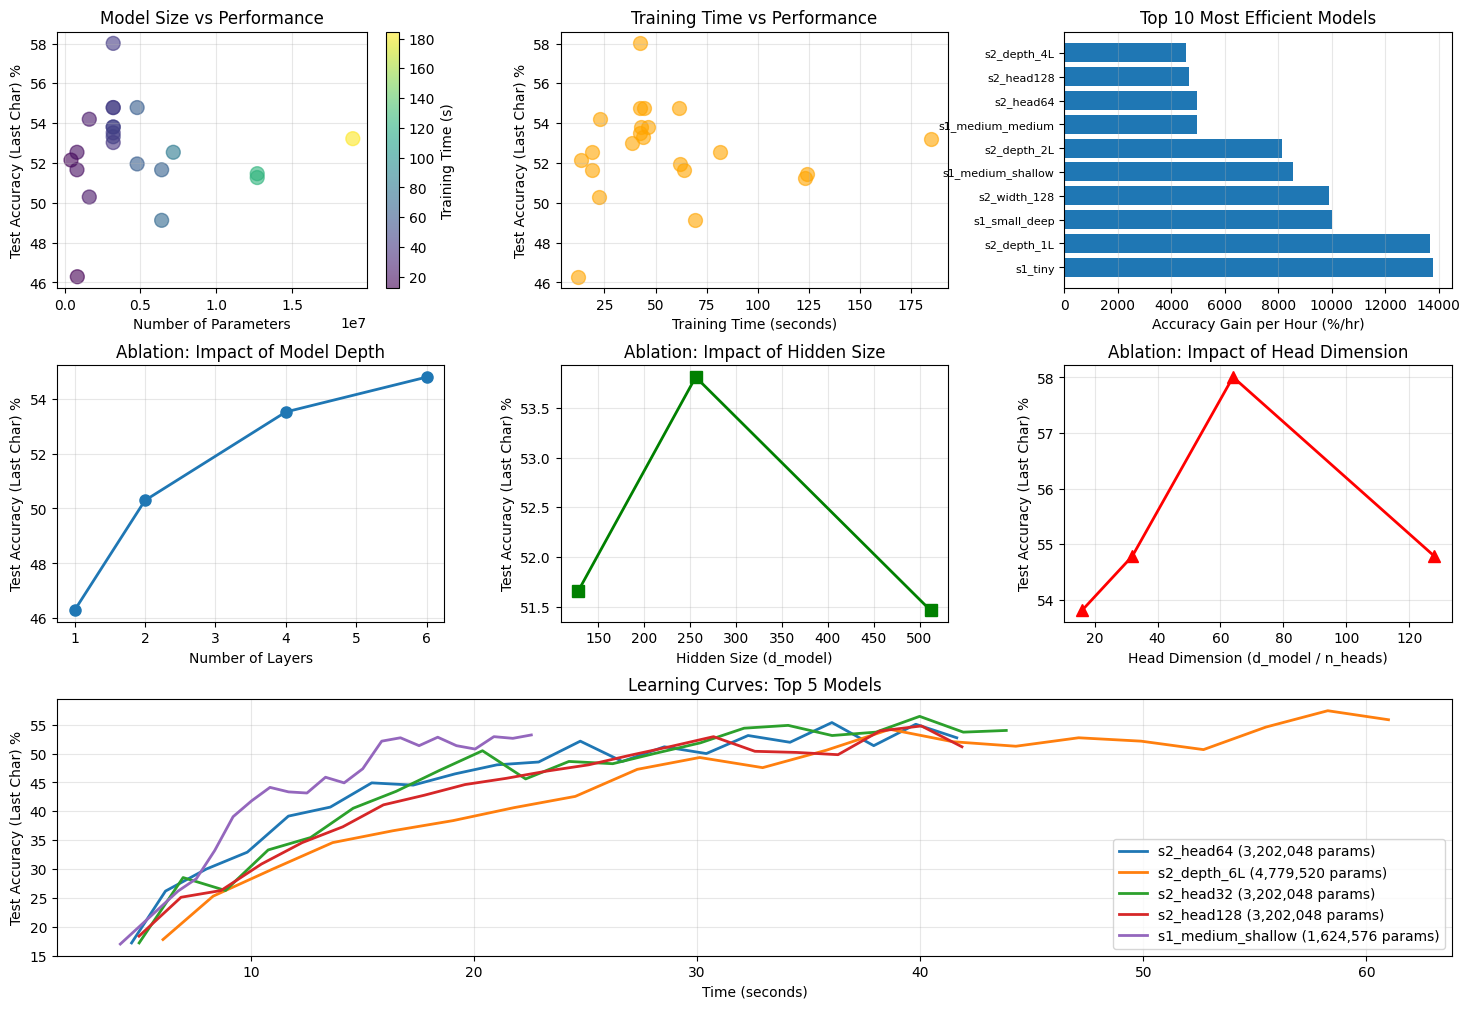

✓ Complexity plot saved to 'model_complexity_vs_cost.png'


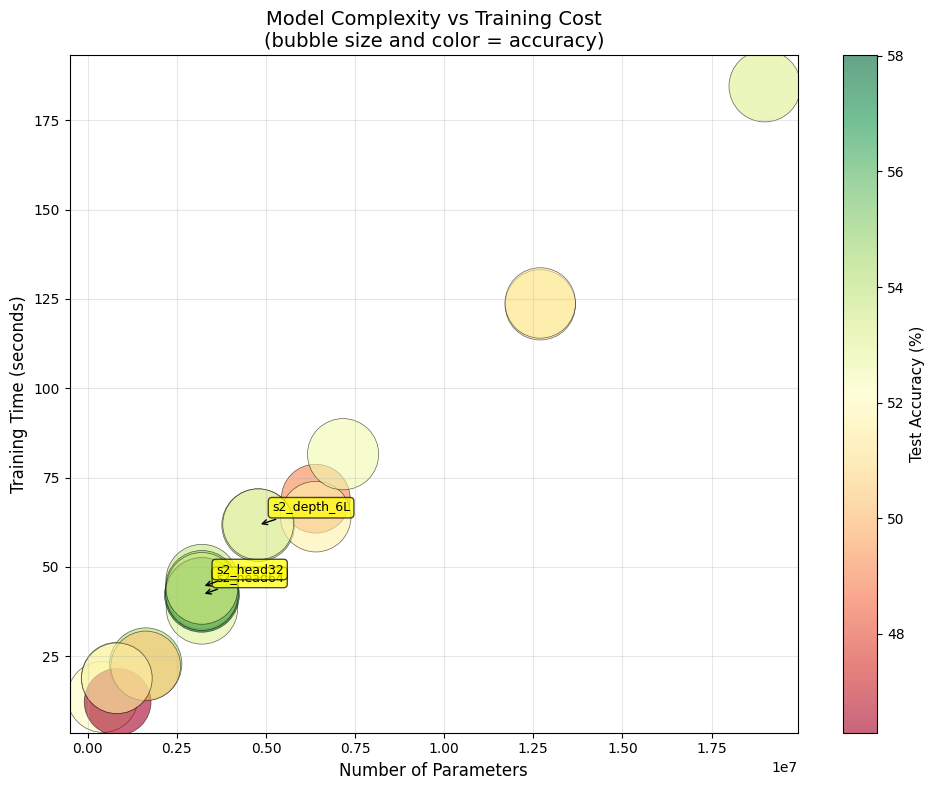

In [17]:
print(f"\n{'='*80}")
print(f"GENERATING PLOTS...")
print(f"{'='*80}\n")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Model size vs accuracy
ax1 = fig.add_subplot(gs[0, 0])
scatter = ax1.scatter(results_df['n_params'], results_df['final_test_acc_last'] * 100, 
                      c=results_df['total_time'], s=100, alpha=0.6, cmap='viridis')
ax1.set_xlabel('Number of Parameters')
ax1.set_ylabel('Test Accuracy (Last Char) %')
ax1.set_title('Model Size vs Performance')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Training Time (s)')

# Plot 2: Training time vs accuracy
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(results_df['total_time'], results_df['final_test_acc_last'] * 100, 
            s=100, alpha=0.6, color='orange')
ax2.set_xlabel('Training Time (seconds)')
ax2.set_ylabel('Test Accuracy (Last Char) %')
ax2.set_title('Training Time vs Performance')
ax2.grid(True, alpha=0.3)

# Plot 3: Efficiency (accuracy per hour)
ax3 = fig.add_subplot(gs[0, 2])
results_df['acc_per_hour'] = results_df['final_test_acc_last'] * 100 / (results_df['total_time'] / 3600)
top_efficient = results_df.nlargest(10, 'acc_per_hour')
ax3.barh(range(len(top_efficient)), top_efficient['acc_per_hour'])
ax3.set_yticks(range(len(top_efficient)))
ax3.set_yticklabels(top_efficient['name'], fontsize=8)
ax3.set_xlabel('Accuracy Gain per Hour (%/hr)')
ax3.set_title('Top 10 Most Efficient Models')
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Impact of depth (ablation group)
ax4 = fig.add_subplot(gs[1, 0])
depth_results = results_df[results_df['group'] == 'depth'].sort_values('n_layers')
if len(depth_results) > 0:
    ax4.plot(depth_results['n_layers'], depth_results['final_test_acc_last'] * 100, 
             marker='o', linewidth=2, markersize=8)
    ax4.set_xlabel('Number of Layers')
    ax4.set_ylabel('Test Accuracy (Last Char) %')
    ax4.set_title('Ablation: Impact of Model Depth')
    ax4.grid(True, alpha=0.3)

# Plot 5: Impact of width (ablation group)
ax5 = fig.add_subplot(gs[1, 1])
width_results = results_df[results_df['group'] == 'width'].sort_values('d_model')
if len(width_results) > 0:
    ax5.plot(width_results['d_model'], width_results['final_test_acc_last'] * 100, 
             marker='s', linewidth=2, markersize=8, color='green')
    ax5.set_xlabel('Hidden Size (d_model)')
    ax5.set_ylabel('Test Accuracy (Last Char) %')
    ax5.set_title('Ablation: Impact of Hidden Size')
    ax5.grid(True, alpha=0.3)

# Plot 6: Impact of head_dim (ablation group)
ax6 = fig.add_subplot(gs[1, 2])
head_results = results_df[results_df['group'] == 'head_dim'].sort_values('head_dim')
if len(head_results) > 0:
    ax6.plot(head_results['head_dim'], head_results['final_test_acc_last'] * 100, 
             marker='^', linewidth=2, markersize=8, color='red')
    ax6.set_xlabel('Head Dimension (d_model / n_heads)')
    ax6.set_ylabel('Test Accuracy (Last Char) %')
    ax6.set_title('Ablation: Impact of Head Dimension')
    ax6.grid(True, alpha=0.3)

# Plot 7: Training curves (top 5 models)
ax7 = fig.add_subplot(gs[2, :])
top5 = results_df.nlargest(5, 'final_test_acc_last')
for idx, row in top5.iterrows():
    history = row['history']
    ax7.plot(history['time_elapsed'], 
             [x*100 for x in history['test_acc_last']], 
             label=f"{row['name']} ({row['n_params']:,} params)", 
             linewidth=2)
ax7.set_xlabel('Time (seconds)')
ax7.set_ylabel('Test Accuracy (Last Char) %')
ax7.set_title('Learning Curves: Top 5 Models')
ax7.legend(loc='lower right')
ax7.grid(True, alpha=0.3)

plt.savefig('hyperparameter_search_results.png', dpi=300, bbox_inches='tight')
print(f"✓ Main plot saved to 'hyperparameter_search_results.png'")
plt.show()

# Additional plot: Params vs Time vs Accuracy (3D-like)
fig2, ax = plt.subplots(1, 1, figsize=(10, 8))
scatter = ax.scatter(results_df['n_params'], 
                     results_df['total_time'], 
                     s=results_df['final_test_acc_last']*5000,  # size = accuracy
                     c=results_df['final_test_acc_last']*100,
                     cmap='RdYlGn', 
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)
ax.set_xlabel('Number of Parameters', fontsize=12)
ax.set_ylabel('Training Time (seconds)', fontsize=12)
ax.set_title('Model Complexity vs Training Cost\n(bubble size and color = accuracy)', fontsize=14)
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Test Accuracy (%)', fontsize=11)

# Annotate best models
top3 = results_df.nlargest(3, 'final_test_acc_last')
for idx, row in top3.iterrows():
    ax.annotate(row['name'], 
                (row['n_params'], row['total_time']),
                xytext=(10, 10), 
                textcoords='offset points',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.savefig('model_complexity_vs_cost.png', dpi=300, bbox_inches='tight')
print(f"✓ Complexity plot saved to 'model_complexity_vs_cost.png'")
plt.show()

# Download

In [18]:
import zipfile
import os
from datetime import datetime

print(f"\n{'='*80}")
print(f"CREATING DOWNLOADABLE PACKAGE...")
print(f"{'='*80}\n")

# Create a timestamp for the filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_filename = f'architecture_search_results_{timestamp}.zip'

# List of files to include in the zip
files_to_zip = [
    'experiment_results_final.csv',
    'training_histories.json',
    'hyperparameter_search_results.png',
    'model_complexity_vs_cost.png',
]

# Create a summary text file
summary_filename = 'experiment_summary.txt'
with open(summary_filename, 'w') as f:
    f.write("="*80 + "\n")
    f.write("ARCHITECTURE SEARCH EXPERIMENT SUMMARY\n")
    f.write("="*80 + "\n\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Total configurations tested: {len(results_df)}\n")
    f.write(f"Total experiment time: {total_experiment_time/60:.1f} minutes\n\n")
    
    f.write("="*80 + "\n")
    f.write("TOP 10 MODELS BY TEST ACCURACY (LAST CHARACTER)\n")
    f.write("="*80 + "\n")
    f.write(results_df_sorted[top10_cols].head(10).to_string(index=False))
    f.write("\n\n")
    
    f.write("="*80 + "\n")
    f.write("BEST MODEL IN EACH EXPERIMENTAL GROUP\n")
    f.write("="*80 + "\n")
    for group in results_df['group'].unique():
        group_df = results_df[results_df['group'] == group]
        best_in_group = group_df.sort_values('final_test_acc_last', ascending=False).iloc[0]
        f.write(f"{group:15s} : {best_in_group['name']:20s} ")
        f.write(f"acc={100*best_in_group['final_test_acc_last']:.2f}% ")
        f.write(f"params={best_in_group['n_params']:,}\n")
    f.write("\n")
    
    f.write("="*80 + "\n")
    f.write("ALL CONFIGURATIONS SUMMARY\n")
    f.write("="*80 + "\n")
    f.write(results_df[summary_cols].to_string(index=False))
    f.write("\n")

files_to_zip.append(summary_filename)

# Create the zip file
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file, arcname=file)
            print(f"  ✓ Added: {file}")
        else:
            print(f"  ✗ Missing: {file}")

print(f"\n{'='*80}")
print(f"PACKAGE CREATED SUCCESSFULLY!")
print(f"{'='*80}\n")
print(f"Zip file: {zip_filename}")
print(f"Size: {os.path.getsize(zip_filename) / 1024:.2f} KB")

# ============================================================================
# DISPLAY DOWNLOAD LINKS (KAGGLE SPECIFIC)
# ============================================================================

from IPython.display import FileLink, display, HTML

print(f"\n{'='*80}")
print(f"DOWNLOAD YOUR RESULTS")
print(f"{'='*80}\n")

# Create download links
print("📦 Download the complete package:")
display(FileLink(zip_filename))

print("\n📄 Or download individual files:")
for file in files_to_zip:
    if os.path.exists(file):
        display(FileLink(file))

# Also create an HTML summary for easier viewing in Kaggle
html_summary = f"""
<div style="background-color: #f0f0f0; padding: 20px; border-radius: 10px; margin: 20px 0;">
    <h2 style="color: #2c3e50;">🎯 Experiment Complete!</h2>
    <h3>Download Options:</h3>
    <ul style="font-size: 14px;">
        <li><strong>Complete Package:</strong> <code>{zip_filename}</code> - Contains all results, plots, and summaries</li>
        <li><strong>CSV Results:</strong> <code>experiment_results_final.csv</code> - For analysis in Excel/Python</li>
        <li><strong>Training Histories:</strong> <code>training_histories.json</code> - Detailed training curves</li>
        <li><strong>Plots:</strong> PNG files for your report</li>
        <li><strong>Summary:</strong> <code>experiment_summary.txt</code> - Text summary of all results</li>
    </ul>
    <h3>Top 3 Models:</h3>
    <ol>
"""

for idx, (_, row) in enumerate(results_df_sorted.head(3).iterrows(), 1):
    html_summary += f"""
        <li><strong>{row['name']}</strong>: 
            {100*row['final_test_acc_last']:.2f}% accuracy 
            ({row['n_params']:,} params, {row['total_time']:.0f}s training)
        </li>
    """

html_summary += """
    </ol>
    <p style="margin-top: 20px; font-style: italic;">
        💡 Click the links above to download files directly from Kaggle!
    </p>
</div>
"""

display(HTML(html_summary))

print(f"\n{'='*80}")
print(f"EXPERIMENT COMPLETE!")
print(f"{'='*80}\n")
print(f"Next steps:")
print(f"1. Download the zip file or individual files using the links above")
print(f"2. Review the plots and tables")
print(f"3. Identify the top 2-3 architectures")
print(f"4. Add them to stage4_configs and train for 150k iterations")
print(f"5. Use the best model for your final report")
print(f"\n{'='*80}\n")

# ============================================================================
# KAGGLE OUTPUT PATH (ALTERNATIVE METHOD)
# ============================================================================
# If the FileLink method doesn't work, files are also available at:
print("📁 Files are also saved in the working directory:")
print(f"   {os.getcwd()}")
print("\n   You can find them in the Kaggle output section after the notebook runs.")


CREATING DOWNLOADABLE PACKAGE...

  ✓ Added: experiment_results_final.csv
  ✓ Added: training_histories.json
  ✓ Added: hyperparameter_search_results.png
  ✓ Added: model_complexity_vs_cost.png
  ✓ Added: experiment_summary.txt

PACKAGE CREATED SUCCESSFULLY!

Zip file: architecture_search_results_20251101_123654.zip
Size: 1038.21 KB

DOWNLOAD YOUR RESULTS

📦 Download the complete package:


/kaggle/working/char-llm-assignment/architecture_search_results_20251101_123654.zip


📄 Or download individual files:


/kaggle/working/char-llm-assignment/experiment_results_final.csv

/kaggle/working/char-llm-assignment/training_histories.json

/kaggle/working/char-llm-assignment/hyperparameter_search_results.png

/kaggle/working/char-llm-assignment/model_complexity_vs_cost.png

/kaggle/working/char-llm-assignment/experiment_summary.txt


EXPERIMENT COMPLETE!

Next steps:
1. Download the zip file or individual files using the links above
2. Review the plots and tables
3. Identify the top 2-3 architectures
4. Add them to stage4_configs and train for 150k iterations
5. Use the best model for your final report


📁 Files are also saved in the working directory:
   /kaggle/working/char-llm-assignment

   You can find them in the Kaggle output section after the notebook runs.
